In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as col
import matplotlib.patches as mpatches


'J. Guðmunds\xadson'

In [28]:
team=pd.read_json(r"C:\Users\simon\Desktop\ADM\ADM Homework 2\teams.json")
team=team[:98]
team = pd.concat([team,pd.DataFrame(list(team['area']))],axis = 1).drop('area',axis = 1)
pl_teams = pd.DataFrame(team[team.id == '0'])
teams = pd.DataFrame({'Name' : list(pl_teams.officialName), 'ID' : list(pl_teams['wyId'])})

In [131]:
players = pd.read_json(r"C:\Users\simon\Desktop\ADM\ADM Homework 2\players.json")
pl_players = players[players.currentTeamId.isin(teams.ID)]
pl_players = pl_players.reset_index().drop('index', axis = 1)

#Changing the ShortName column's encoding, so that Names are displayed correctly
a = []
for i in range(len(pl_players.shortName)):
    a.append(pl_players.shortName[i].encode('ascii').decode('unicode escape'))
pl_players.shortName = a    

In [133]:
heights = pd.DataFrame({'Id' : pl_players.wyId, 'Name': pl_players.shortName, 'Height' : pl_players.height})
heights.head()

,Id,Name,Height
0,36,T. Alderweireld,187
1,48,J. Vertonghen,189
2,54,C. Eriksen,180
3,93,J. Guðmunds­son,186
4,261,N. Chadli,187


In [142]:
eng_events = pd.read_json(r"C:\Users\simon\Desktop\ADM\ADM Homework 2\events\events_England.json")

In the England events database, some events are related to players currently playing in minor league teams, along with events of Premier league players. We select only the premier league players, which we have stored in the data frame called 'heights'.

In [143]:
pl_events = eng_events[eng_events.playerId.isin(heights.Id)]
pl_events[pl_events.subEventName == 'Air duel'].head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
7,1,Duel,14.765321,177959189,2499719,1H,8013,"[{'y': 15, 'x': 39}, {'y': 20, 'x': 33}]",10,Air duel,"[{'id': 701}, {'id': 1802}]",1631
12,1,Duel,21.878309,177959191,2499719,1H,8653,"[{'y': 46, 'x': 29}, {'y': 41, 'x': 50}]",10,Air duel,"[{'id': 703}, {'id': 1801}]",1631
13,1,Duel,22.551816,177959181,2499719,1H,25413,"[{'y': 54, 'x': 71}, {'y': 59, 'x': 50}]",10,Air duel,"[{'id': 701}, {'id': 1802}]",1609
27,1,Duel,47.717508,177959210,2499719,1H,192748,"[{'y': 56, 'x': 60}, {'y': 49, 'x': 56}]",10,Air duel,"[{'id': 703}, {'id': 1801}]",1631
28,1,Duel,48.265872,177959188,2499719,1H,7945,"[{'y': 44, 'x': 40}, {'y': 51, 'x': 44}]",10,Air duel,"[{'id': 701}, {'id': 1802}]",1609


In [144]:
air_duels = pl_events[pl_events.subEventName == 'Air duel'].reset_index().drop('index', axis = 1)
air_duels.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
0,1,Duel,14.765321,177959189,2499719,1H,8013,"[{'y': 15, 'x': 39}, {'y': 20, 'x': 33}]",10,Air duel,"[{'id': 701}, {'id': 1802}]",1631
1,1,Duel,21.878309,177959191,2499719,1H,8653,"[{'y': 46, 'x': 29}, {'y': 41, 'x': 50}]",10,Air duel,"[{'id': 703}, {'id': 1801}]",1631
2,1,Duel,22.551816,177959181,2499719,1H,25413,"[{'y': 54, 'x': 71}, {'y': 59, 'x': 50}]",10,Air duel,"[{'id': 701}, {'id': 1802}]",1609
3,1,Duel,47.717508,177959210,2499719,1H,192748,"[{'y': 56, 'x': 60}, {'y': 49, 'x': 56}]",10,Air duel,"[{'id': 703}, {'id': 1801}]",1631
4,1,Duel,48.265872,177959188,2499719,1H,7945,"[{'y': 44, 'x': 40}, {'y': 51, 'x': 44}]",10,Air duel,"[{'id': 701}, {'id': 1802}]",1609


In [145]:
ad_byplayer = air_duels.groupby(air_duels.playerId).size()

In [146]:
tot_ad = pd.DataFrame({'Id' : ad_byplayer.keys(), 'Air_duels' : ad_byplayer.values})

Merging the air duel counts with the 'heights' data frame, some players Ids are dropped, which means that there'sno eir duel event associated to those players during the season. That's plausible, because some players, i.e. goalkeepers, would hardly ever do air duels. We can continue the analysis on this frame with reduced rows, beacuse we are only interested about players who have at least one air duel during the season. In fact, we will further reduce the data frame, dropping players who didn't reach a threshold value of air duels, in order to have significant statistics.

In [147]:
df = pd.merge(heights, tot_ad, how='inner')

We choose to take as "air duelers" only the players who have performed at least 1 air duel per game on average. Considering that each team has played 38 games during the season, we take the threshold value of 38 air duels. This value is well-suited for the task of making the won air duel rate meaningful, being high enough to cut-off the players who don't "usually" engage in air duels, and low enough to keep a good part of observations (about 60% of players that carried out at least one air duel during the season, fall in our class of air duelers). Of course there could be other values well-suited for the task, like cutting at the first quartile, or at the tenth percentile, but the value choosen has an easy to understand meaning without requiring further investigations, and gives a wide enough denominator to calculate the success rates. 

In [148]:
air_duelers = df[df.Air_duels > 38]
print("Air Duelers: {}".format(len(air_duelers)), '\nRate of air duelers: {}'.format(round(len(air_duelers)/len(df), 3)))

Air Duelers: 234 
Rate of air duelers: 0.598


Now we want to analyze the won air duels rates of our air duelers.

In [149]:
won_airduels = air_duels[[{'id': 1801} in air_duels.tags[i] for i in range(len(air_duels))]]

In [150]:
won_byplayer = won_airduels.groupby(won_airduels.playerId).size()
won_ad = pd.DataFrame({'Id' : won_byplayer.keys(), 'Won_duels' : won_byplayer.values})

In [173]:
df = pd.merge(air_duelers, won_ad, how='inner')
df['Rates'] =  round(df.Won_duels/df.Air_duels, 3)
display(df.sort_values(by = 'Rates', ascending=False).head().style.set_caption('<strong>''First 5 players by won air duels Rates'),
        df.sort_values(by = 'Won_duels', ascending=False).head().style.set_caption('<strong>''First 5 players by won air duels'))

,Id,Name,Height,Air_duels,Won_duels,Rates
222,256998,E. Bailly,187,41,36,0.878
33,9380,J. Stones,188,48,40,0.833
26,8307,V. Kompany,193,64,53,0.828
7,135103,A. Christensen,188,96,77,0.802
80,25854,K. Zouma,190,170,135,0.794


,Id,Name,Height,Air_duels,Won_duels,Rates
145,38031,C. Benteke,190,497,318,0.64
96,8747,P. Crouch,201,426,292,0.685
75,8242,S. Duffy,193,337,256,0.76
226,293687,D. Calvert-Lewin,176,395,204,0.516
181,15215,C. Schindler,189,274,194,0.708


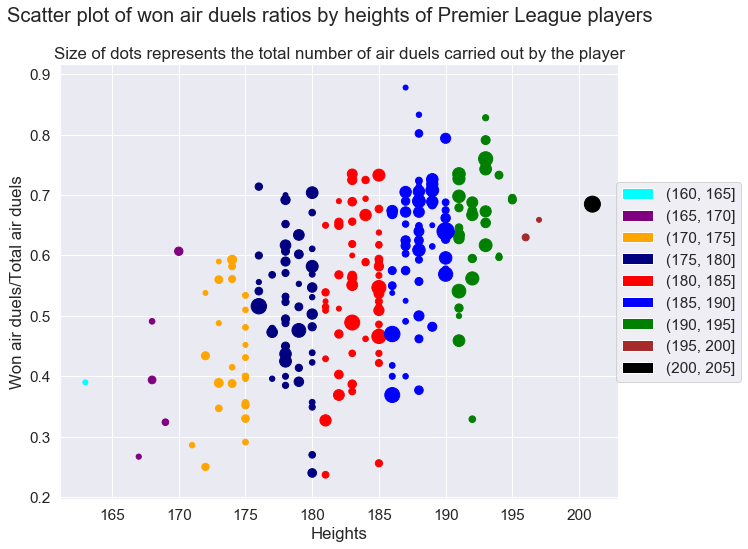

In [177]:
fig = plt.figure()
fig.set_size_inches(10, 8)
sns.set(font_scale=1.4)
bins = range(160, 206 , 5)
df.groupby(pd.cut(df.Height, bins))
colors = ['cyan', 'purple','orange', 'navy', 'red', 'blue', 'green', 'brown', 'black']
plt.scatter(df.Height, df.Rates, s = df.Air_duels*0.6, c = pd.cut(df.Height, bins).cat.codes, cmap = col.ListedColormap(colors))
recs = []
for i in range(len(colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=colors[i]))
plt.legend(recs,df.groupby(pd.cut(df.Height, bins)).indices.keys(),loc="center right", borderaxespad = -8)
plt.title('Size of dots represents the total number of air duels carried out by the player')
plt.suptitle('Scatter plot of won air duels ratios by heights of Premier League players')
plt.xlabel('Heights')
plt.ylabel('Won air duels/Total air duels')
plt.show()

As the plot shows, there's an evident relationship between the height of a player and his success ratio in air duels. Moreover, there's a clear association between the number of total air duels carried out by a player and his height (bigger dots on the right of the plot), meaning that shorter players tend not to engage in air duels, and when they do, they tend to lose them (lower succes ratios on the left side of the plot). The plot also shows that players with heights between 190cm and 195cm are the best at winning air duels on average, with success ratios higher than 60% for more than half of them